## Import Necessary Libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import sqlalchemy as db
import yfinance as yf
import json
import requests
import os
import wbgapi as wb


from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
from pymongo import MongoClient

import warnings
warnings.filterwarnings('ignore')

## Extract Covid19 & Vaccination Data from WHO

In [4]:
base_url = "https://data.who.int/dashboards/covid19/data"
os.makedirs(os.getcwd(), exist_ok=True)

response = requests.get(base_url)

soup = BeautifulSoup(response.text, 'html.parser')

download_links = []
for link in soup.find_all('a', href=True):
    href = link['href']
    if href.endswith('.csv'):
        full_url = urljoin(base_url, href)
        download_links.append(full_url)

for file_url in download_links:
    file_name = os.path.basename(file_url)
    file_path = os.path.join(file_name)

    print(f"Downloading {file_url}...")
    file_response = requests.get(file_url)
    file_response.raise_for_status()

    with open(file_path, "wb") as file:
        file.write(file_response.content)
    print(f"Saved to {file_path}")

print("Download complete.")

covid_who_data = pd.read_csv("WHO-COVID-19-global-daily-data.csv")
covid_vaccine_who_data = pd.read_csv("vaccination-data.csv")

data = {"covid_who_data": covid_who_data, "covid_vaccine_who_data": covid_vaccine_who_data}

Saved to WHO-COVID-19-global-daily-data.csv
Saved to WHO-COVID-19-global-data.csv
Saved to WHO-COVID-19-global-table-data.csv
Saved to vaccination-data.csv
Saved to vaccination-metadata.csv
Download complete.


## Data Preprocessing

In [6]:
# Load the datasets
vaccination_metadata = pd.read_csv('vaccination-metadata.csv')
covid_global_data = pd.read_csv('WHO-COVID-19-global-daily-data.csv')

In [7]:
# Define function to clean the datasets
def clean_dataset(df, rename_columns=None, drop_duplicates=True, fill_na=0, numeric_columns=None):
    # Rename columns
    if rename_columns:
        df.rename(columns=rename_columns, inplace=True)

    # Drop duplicates
    if drop_duplicates:
        df.drop_duplicates(inplace=True)

    # Fill missing values
    if fill_na is not None:
        df.fillna(fill_na, inplace=True)

    # Remove blank rows (if any)
    df.replace(r'^\s*$', fill_na, regex=True, inplace=True)  # Replace empty strings with fill value
    df.dropna(how='all', inplace=True)  # Remove rows that are entirely NaN

    # Ensure column names and indices are clean
    df.reset_index(drop=True, inplace=True)

    # Remove rows with negative values in numeric columns
    if numeric_columns:
        for column in numeric_columns:
            if column in df.columns:
                df = df[df[column] >= 0]

    return df

In [8]:
# Cleaning vaccination metadata
vaccination_metadata_final = clean_dataset(
    vaccination_metadata,
    rename_columns={
        "ISO3": "Country_Code",
        "PRODUCT_NAME": "Product_Name",
        "VACCINE_NAME": "Vaccine_Name",
        "COMPANY_NAME": "Company_Name",
        "AUTHORIZATION_DATE": "Authorization_Date",
        "START_DATE": "Start_Date",
        "END_DATE": "End_Date"
    }
)

# Cleaning WHO COVID-19 global daily data
covid_global_data_final = clean_dataset(
    covid_global_data,
    rename_columns={
        "Date_reported": "Date_Reported",
        "Country_code": "Country_Code",
        "Country": "Country_Name",
        "WHO_region": "WHO_Region",
        "New_cases": "New_Cases",
        "Cumulative_cases": "Cumulative_Cases",
        "New_deaths": "New_Deaths",
        "Cumulative_deaths": "Cumulative_Deaths"
    },
    numeric_columns=["New_Cases", "Cumulative_Cases", "New_Deaths", "Cumulative_Deaths"]
)

In [9]:
# Converting Date_Reported to datetime
covid_global_data_final["Date_Reported"] = pd.to_datetime(covid_global_data_final["Date_Reported"], errors='coerce')

In [10]:
# Saving cleaned datasets to new CSV files
vaccination_metadata_final.to_csv("Validated_Final_Vaccination_Metadata.csv", index=False)
covid_global_data_final.to_csv("Validated_Final_WHO_COVID-19_Global_Data.csv", index=False)

## Covid-19 Data Visualisation

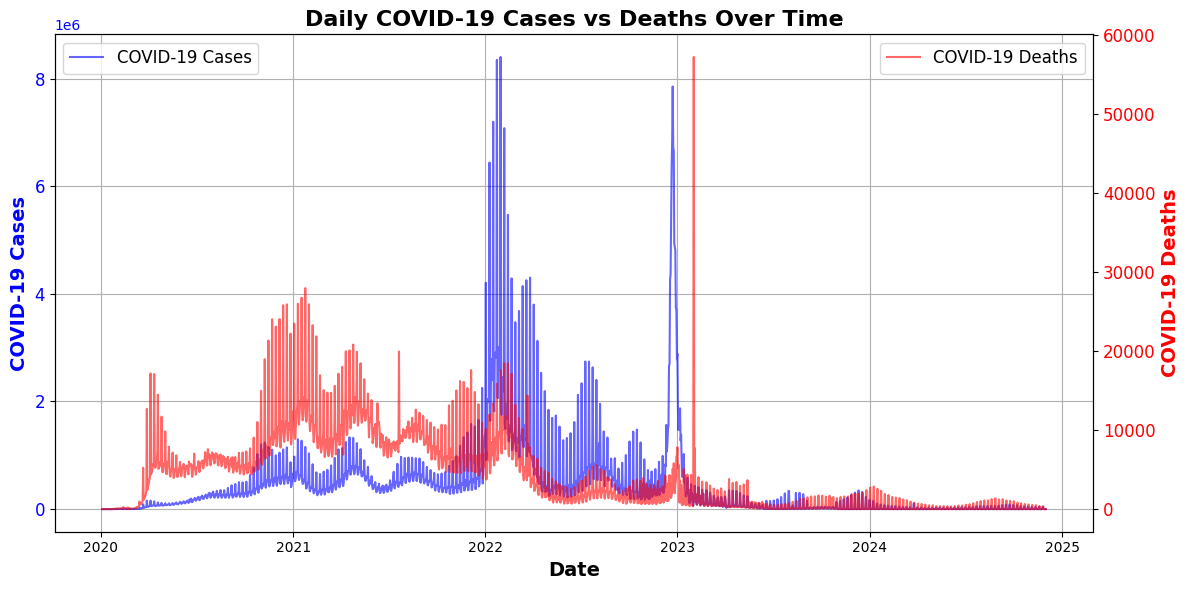

In [12]:
# Aggregate data by date globally
covid_aggregated = covid_global_data_final.groupby("Date_Reported").agg(
    {"New_Cases": "sum", "New_Deaths": "sum"}
).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting COVID-19 Cases with Primary Y-axis
ax1.set_xlabel('Date', fontsize=14, weight='bold')
ax1.set_ylabel('COVID-19 Cases', color='blue', fontsize=14, weight='bold')
ax1.plot(
    covid_aggregated['Date_Reported'],
    covid_aggregated['New_Cases'],
    color='blue',
    alpha=0.6,
    label='COVID-19 Cases'
)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True)

# Create a secondary Y-axis for COVI-19 Deaths
ax2 = ax1.twinx()
ax2.set_ylabel('COVID-19 Deaths', color='red', fontsize=14, weight='bold')
ax2.plot(
    covid_aggregated['Date_Reported'],
    covid_aggregated['New_Deaths'],
    color='red',
    alpha=0.6,
    label='COVID-19 Deaths'
)
ax2.tick_params(axis='y', labelcolor='red', labelsize=12)
ax2.legend(loc='upper right', fontsize=12)

plt.title('Daily COVID-19 Cases vs Deaths Over Time', fontsize=16, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.tight_layout()
plt.show()

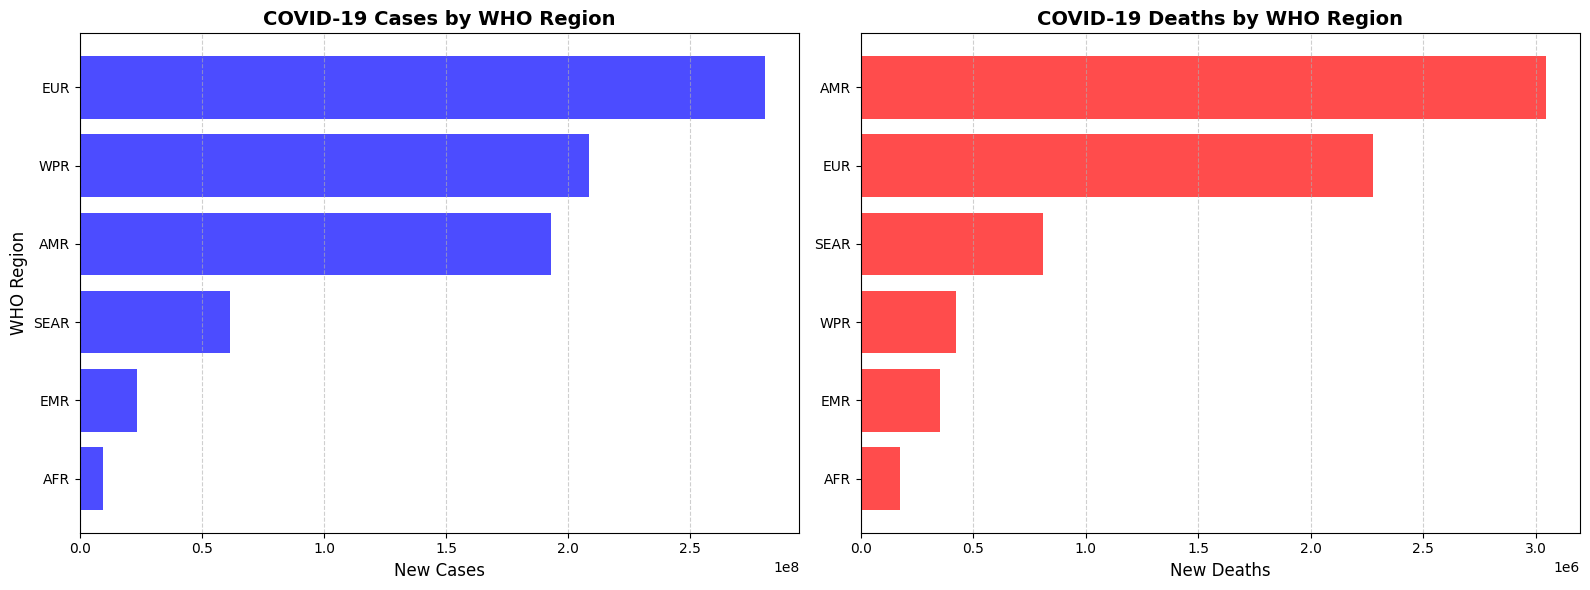

In [13]:
# Aggregating the COVID-19 data by WHO Region
region_aggregated = covid_global_data_final.groupby("WHO_Region").agg({
    "New_Cases": "sum",
    "New_Deaths": "sum"
}).reset_index()

region_filtered = region_aggregated[region_aggregated["WHO_Region"] != "OTHER"]
region_sorted_cases = region_filtered.sort_values(by="New_Cases", ascending=True)
region_sorted_deaths = region_filtered.sort_values(by="New_Deaths", ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
axes[0].barh(region_sorted_cases["WHO_Region"], region_sorted_cases["New_Cases"], color="blue", alpha=0.7)
axes[0].set_title("COVID-19 Cases by WHO Region", fontsize=14, weight="bold")
axes[0].set_xlabel("New Cases", fontsize=12)
axes[0].set_ylabel("WHO Region", fontsize=12)
axes[0].grid(axis="x", linestyle="--", alpha=0.6)

axes[1].barh(region_sorted_deaths["WHO_Region"], region_sorted_deaths["New_Deaths"], color="red", alpha=0.7)
axes[1].set_title("COVID-19 Deaths by WHO Region", fontsize=14, weight="bold")
axes[1].set_xlabel("New Deaths", fontsize=12)
axes[1].grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

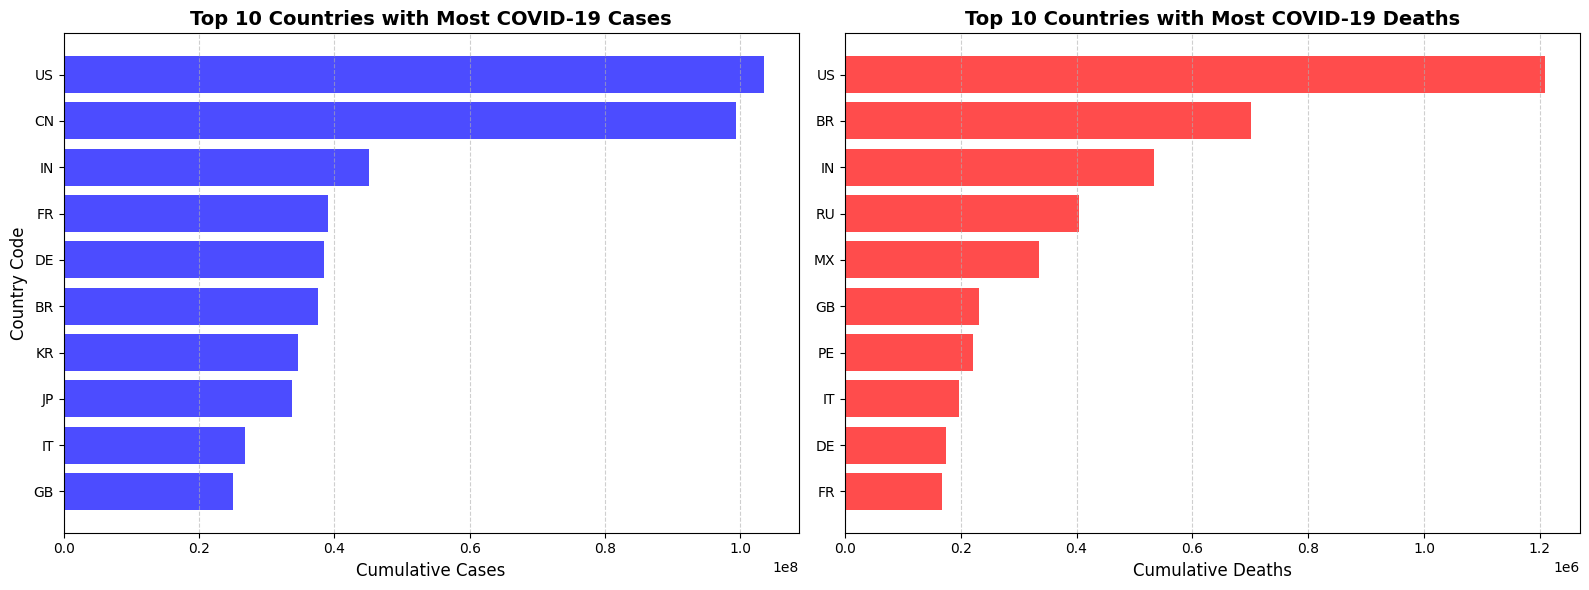

In [14]:
# Aggregate data by country to get total cases and deaths
country_aggregated = covid_global_data_final.groupby("Country_Code").agg(
    {"Cumulative_Cases": "max", "Cumulative_Deaths": "max"}
).reset_index()

# Get the top 10 countries with the most cases and deaths
top_10_cases = country_aggregated.nlargest(10, "Cumulative_Cases")
top_10_deaths = country_aggregated.nlargest(10, "Cumulative_Deaths")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot top 10 countries by cases
axes[0].barh(top_10_cases["Country_Code"], top_10_cases["Cumulative_Cases"], color="blue", alpha=0.7)
axes[0].set_title("Top 10 Countries with Most COVID-19 Cases", fontsize=14, weight="bold")
axes[0].set_xlabel("Cumulative Cases", fontsize=12)
axes[0].set_ylabel("Country Code", fontsize=12)
axes[0].invert_yaxis()
axes[0].grid(axis="x", linestyle="--", alpha=0.6)

# Plot top 10 countries by deaths
axes[1].barh(top_10_deaths["Country_Code"], top_10_deaths["Cumulative_Deaths"], color="red", alpha=0.7)
axes[1].set_title("Top 10 Countries with Most COVID-19 Deaths", fontsize=14, weight="bold")
axes[1].set_xlabel("Cumulative Deaths", fontsize=12)
axes[1].invert_yaxis()
axes[1].grid(axis="x", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

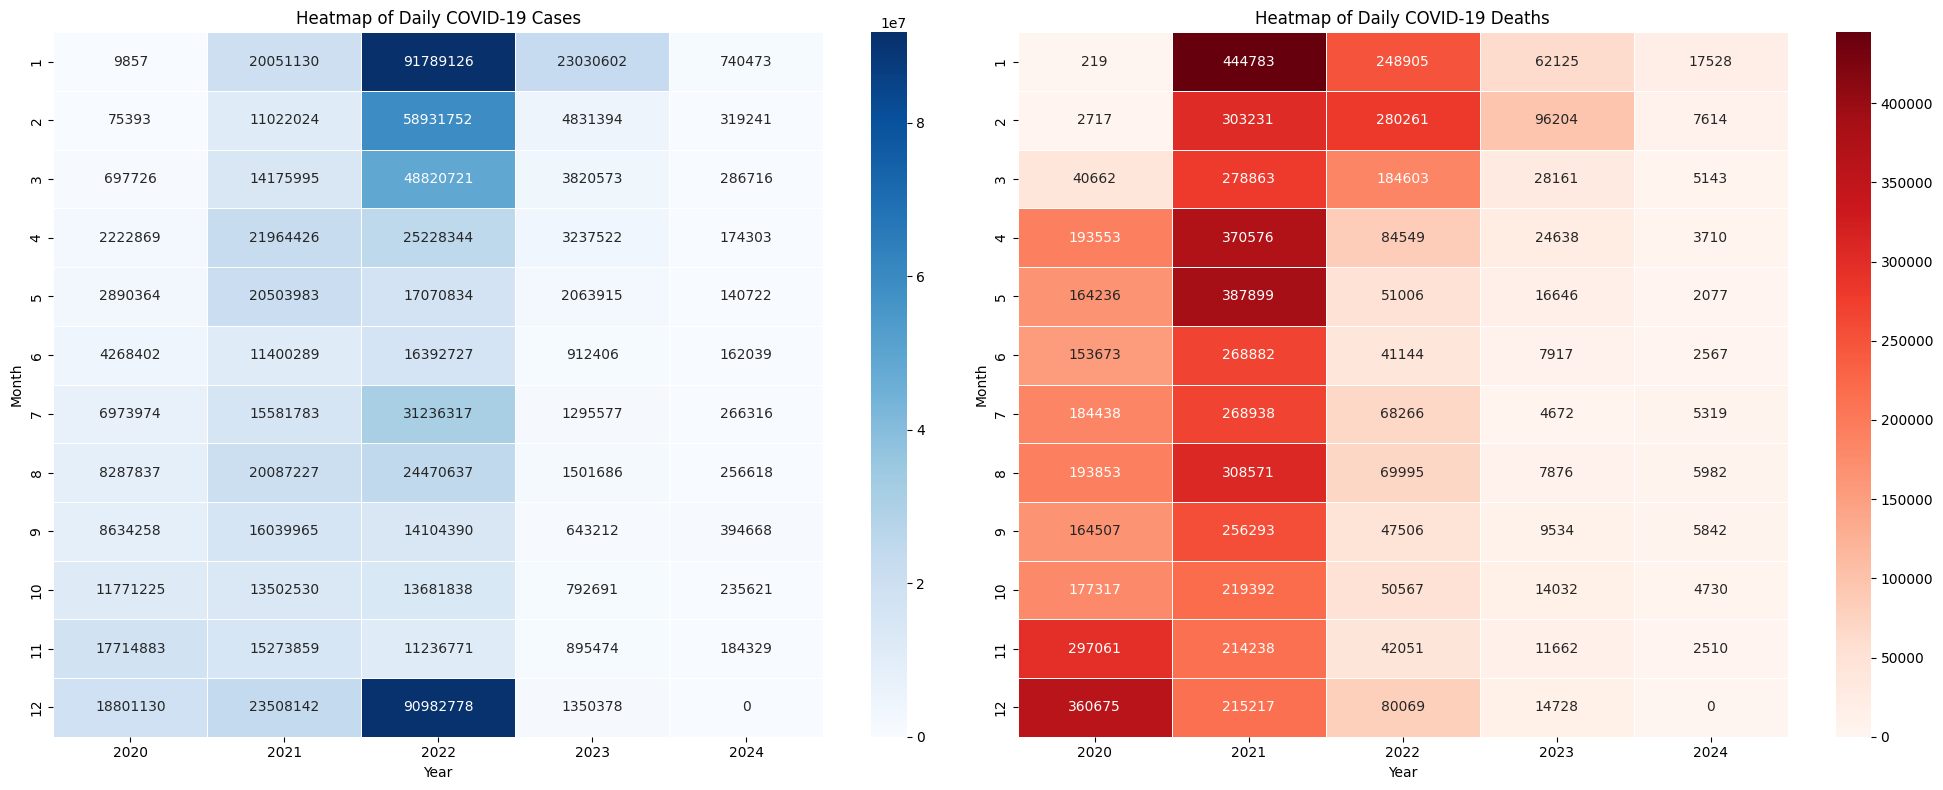

In [15]:
# Extracting Year and Month from the date to categorize the data accordingly
covid_global_data_final['Year'] = covid_global_data_final['Date_Reported'].dt.year
covid_global_data_final['Month'] = covid_global_data_final['Date_Reported'].dt.month

# Pivot tables to create a heatmap-friendly format
daily_cases_pivot = covid_global_data_final.pivot_table(index='Month', columns='Year', values='New_Cases', aggfunc=np.sum)
daily_deaths_pivot = covid_global_data_final.pivot_table(index='Month', columns='Year', values='New_Deaths', aggfunc=np.sum)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(daily_cases_pivot, cmap='Blues', annot=True, fmt=".0f", linewidths=.5, ax=ax1)
ax1.set_title('Heatmap of Daily COVID-19 Cases')
ax1.set_xlabel('Year')
ax1.set_ylabel('Month')

sns.heatmap(daily_deaths_pivot, cmap='Reds', annot=True, fmt=".0f", linewidths=.5, ax=ax2)
ax2.set_title('Heatmap of Daily COVID-19 Deaths')
ax2.set_xlabel('Year')
ax2.set_ylabel('Month')

plt.tight_layout()
plt.show()

## Vaccination Data Visualisation

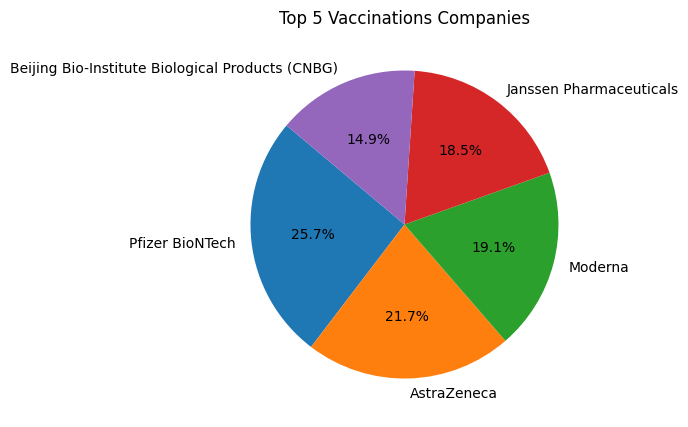

In [17]:
company_vaccine_counts = vaccination_metadata_final['Company_Name'].value_counts()
top_5_companies = company_vaccine_counts.head(5)

plt.figure(figsize=(5, 5))
plt.pie(top_5_companies, labels=top_5_companies.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Vaccinations Companies')
plt.show()

## Stock Market Data Visualisation

[*********************100%***********************]  10 of 10 completed


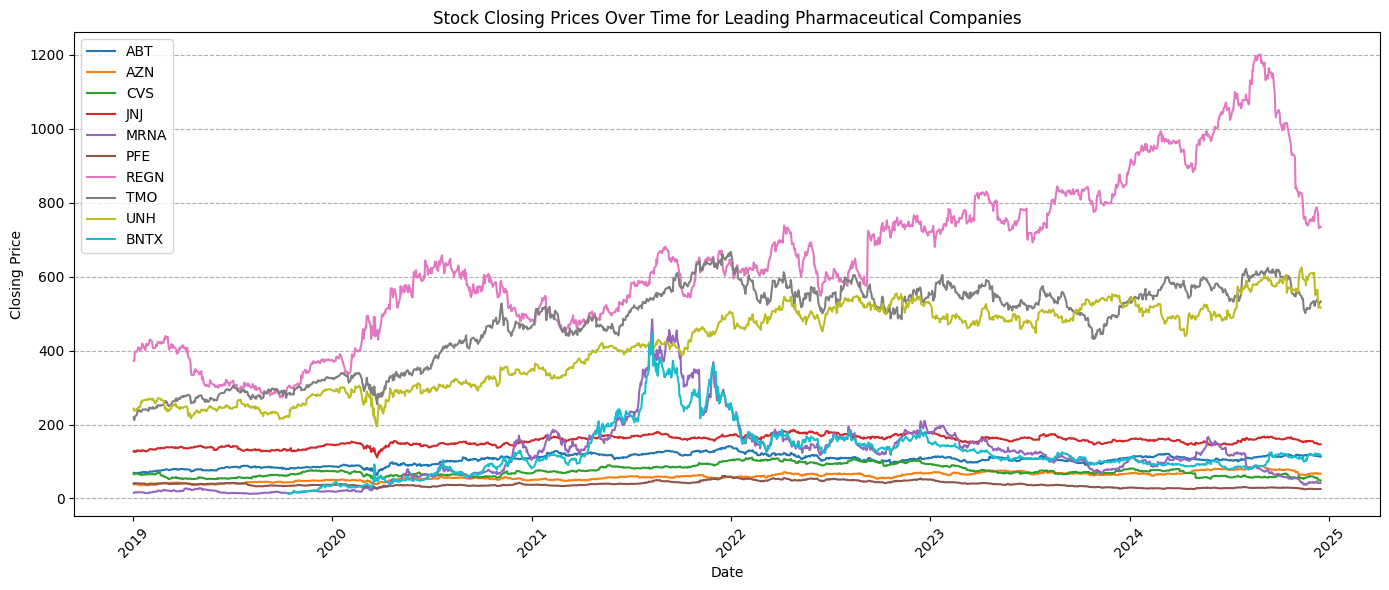

In [19]:
# Define the ticker strings to download data
tickerStrings = ["PFE", "MRNA", "JNJ", "BNTX", "ABT", "TMO", "REGN", "UNH", "CVS", "AZN"]

# Download the stock data using Yahoo Finance
stock_data = yf.download(tickerStrings, group_by='Ticker', period='10y')

# Transform the DataFrame: stack the ticker symbols to create a multi-index
stock_data = stock_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index(level=1).reset_index()

# Filter the data to start from January 1, 2019
filtered_stock_data = stock_data[stock_data['Date'] >= '2019-01-01']

plt.figure(figsize=(14, 6))

for ticker in filtered_stock_data['Ticker'].unique():
    filtered_data = filtered_stock_data[filtered_stock_data['Ticker'] == ticker]
    plt.plot(filtered_data['Date'], filtered_data['Close'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Stock Closing Prices Over Time for Leading Pharmaceutical Companies')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--')
plt.show()

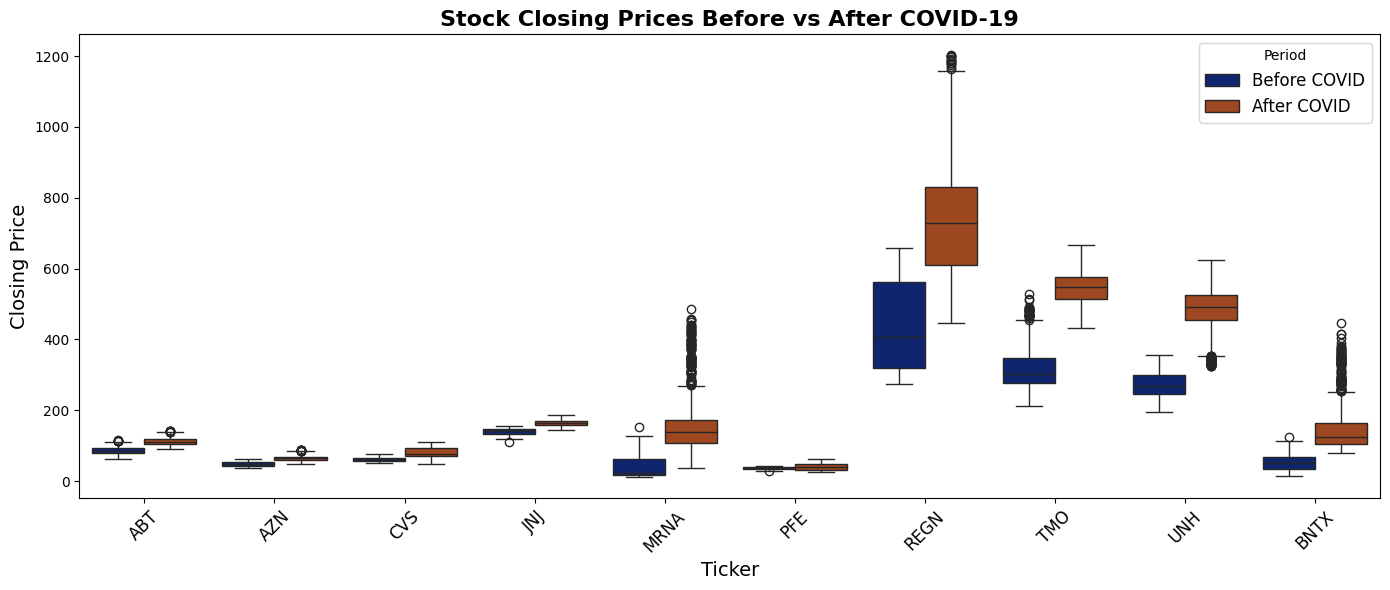

In [20]:
# Define the COVID-19 start date
covid_start_date = '2020-12-01'

# Split data into before and after COVID
before_covid = filtered_stock_data[filtered_stock_data['Date'] < covid_start_date]
after_covid = filtered_stock_data[filtered_stock_data['Date'] >= covid_start_date]

before_covid['Period'] = 'Before COVID'
after_covid['Period'] = 'After COVID'
combined_data = pd.concat([before_covid, after_covid])

plt.figure(figsize=(14, 6))
sns.boxplot(data=combined_data, x='Ticker', y='Close', hue='Period', palette='dark')
plt.title("Stock Closing Prices Before vs After COVID-19", fontsize=16, weight='bold')
plt.xlabel("Ticker", fontsize=14)
plt.ylabel("Closing Price", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Period", loc="upper right", fontsize=12)
plt.tight_layout()
plt.show()

## Economy Impact Data Visualisation

In [22]:
# GDP_growth
gdp_data = wb.data.DataFrame('NY.GDP.MKTP.KD.ZG', labels=True) 
gdp_data = gdp_data.reset_index().rename(columns={"index":"economy"})	
gdp_data = gdp_data.melt(id_vars=('Country','economy'))
gdp_data = gdp_data.rename(columns={'variable': 'Year'})
gdp_data = gdp_data.rename(columns={'value': 'GDP'})
gdp_data.to_csv('Impact_gdb_data.csv')

# Unemployment, total (% of total labor force)
unemployment = wb.data.DataFrame('SL.UEM.TOTL.ZS', labels=True) 
unemployment = unemployment.reset_index().rename(columns={"index":"economy"})	
unemployment = unemployment.melt(id_vars=('Country','economy'))
unemployment = unemployment.rename(columns={'variable': 'Year'})
unemployment = unemployment.rename(columns={'value': 'Unemployment_Percentage'})
unemployment.to_csv('Impact_Unemployment.csv')

# Central government debt, total (% of GDP)
central_government_debt = wb.data.DataFrame('GC.DOD.TOTL.GD.ZS', labels=True) 
central_government_debt = central_government_debt.reset_index().rename(columns={"index":"economy"})	
central_government_debt = central_government_debt.melt(id_vars=('Country','economy'))
central_government_debt = central_government_debt.rename(columns={'variable': 'Year'})
central_government_debt = central_government_debt.rename(columns={'value': 'central_government_debt'})
central_government_debt.to_csv('Impact_central_government_debt.csv')


In [23]:
gdp_data = pd.read_csv("Impact_gdb_data.csv")
unemployment_data = pd.read_csv("Impact_Unemployment.csv")
debt_data = pd.read_csv("Impact_central_government_debt.csv")

In [24]:
# Define the desired year range
start_year = 2000
end_year = 2024
# Convert 'Year' to integer

gdp_data['Year'] = gdp_data['Year'].astype(str).str.extract(r'(\d+)').astype(int)
unemployment_data['Year'] = unemployment_data['Year'].astype(str).str.extract(r'(\d+)').astype(int)
debt_data['Year'] = debt_data['Year'].astype(str).str.extract(r'(\d+)').astype(int)


# Calculate summaries for each dataset
gdp_summary = gdp_data.groupby('Year')['GDP'].mean().reset_index().rename(columns={'GDP': 'GDP Growth (%)'})
unemployment_summary = unemployment_data.groupby('Year')['Unemployment_Percentage'].mean().reset_index().rename(columns={'Unemployment_Percentage': 'Unemployment (%)'})
debt_summary = debt_data.groupby('Year')['central_government_debt'].mean().reset_index().rename(columns={'central_government_debt': 'Government Debt (% of GDP)'})

# Merge summaries (smaller datasets)
summary_data = pd.merge(gdp_summary, unemployment_summary, on='Year', how='inner')
summary_data = pd.merge(summary_data, debt_summary, on='Year', how='inner')
# Filter out extreme outliers from the government debt data
debt_summary_cleaned = debt_summary[debt_summary['Government Debt (% of GDP)'] < 500]  # Adjust threshold as needed


In [25]:
# Filter the datasets by year
gdp_data_filtered = gdp_data[(gdp_data['Year'] >= start_year) & (gdp_data['Year'] <= end_year)]
unemployment_data_filtered = unemployment_data[
    (unemployment_data['Year'] >= start_year) & (unemployment_data['Year'] <= end_year)
]
debt_data_filtered = debt_data[(debt_data['Year'] >= start_year) & (debt_data['Year'] <= end_year)]


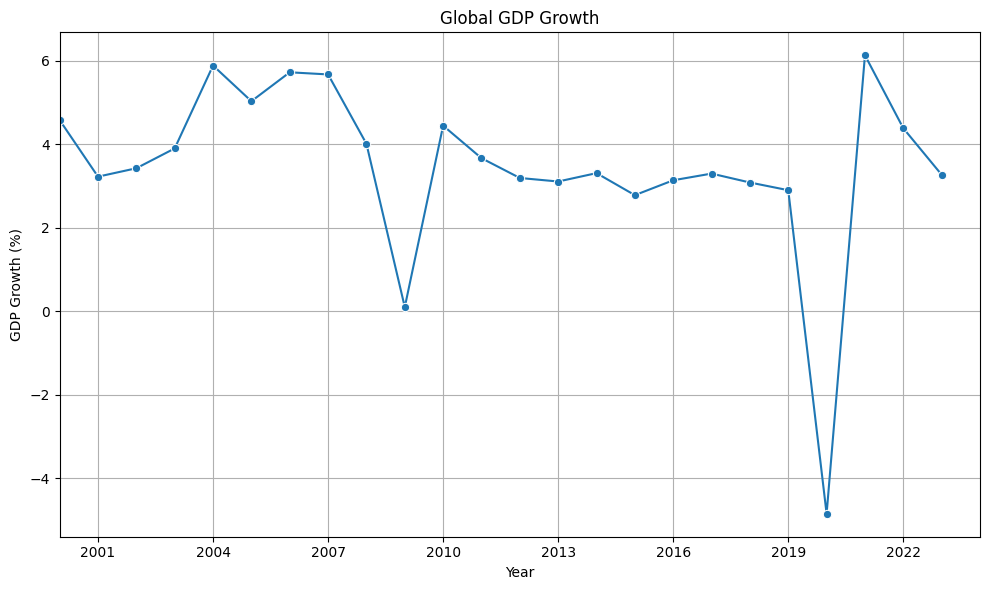

In [26]:
start_year = 2000
end_year = 2024

gdp_summary_filtered = gdp_summary[(gdp_summary['Year'] >= start_year) & (gdp_summary['Year'] <= end_year)]
unemployment_data_filtered = unemployment_data[(unemployment_data['Year'] >= start_year) & (unemployment_data['Year'] <= end_year)]
debt_data_filtered = debt_data[(debt_data['Year'] >= start_year) & (debt_data['Year'] <= end_year)]

# Plot GDP Growth
plt.figure(figsize=(10, 6))
sns.lineplot(data=gdp_summary_filtered, x='Year', y='GDP Growth (%)', marker="o")
plt.title("Global GDP Growth")
plt.xlabel("Year")
plt.ylabel("GDP Growth (%)")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.xlim(start_year, end_year)  
plt.grid(True)
plt.tight_layout()
plt.savefig("Global GDP Growth.pdf")
plt.show()


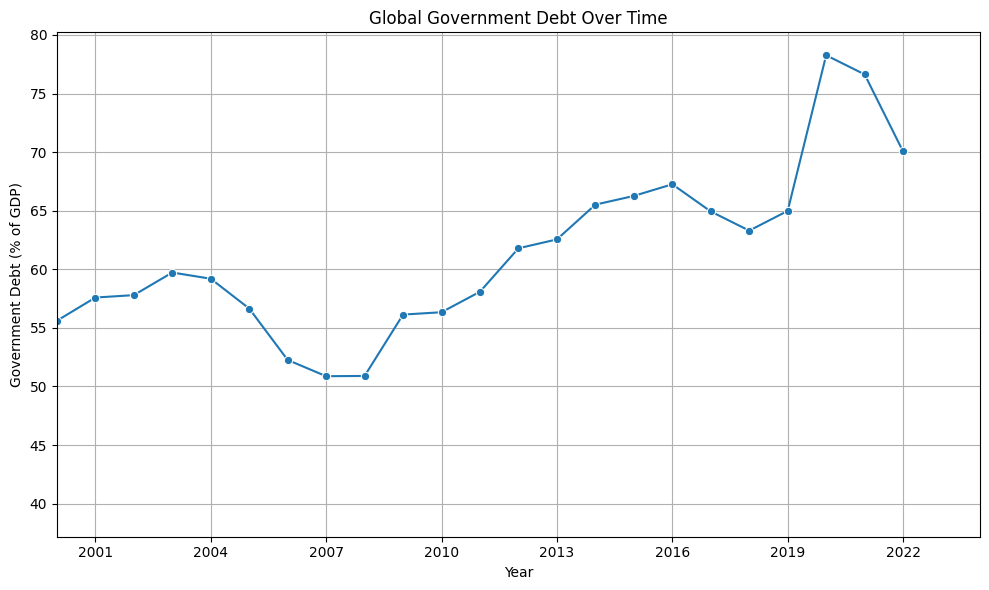

In [27]:
# Plot the cleaned data
plt.figure(figsize=(10, 6))
sns.lineplot(data=debt_summary_cleaned, x='Year', y='Government Debt (% of GDP)', marker="o")
plt.title("Global Government Debt Over Time")
plt.xlabel("Year")
plt.ylabel("Government Debt (% of GDP)")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # Ensure integer-only year ticks
plt.xlim(start_year, end_year)  
plt.grid(True)
plt.tight_layout()
plt.savefig("Global Government Debt Over Time.pdf")
plt.show()

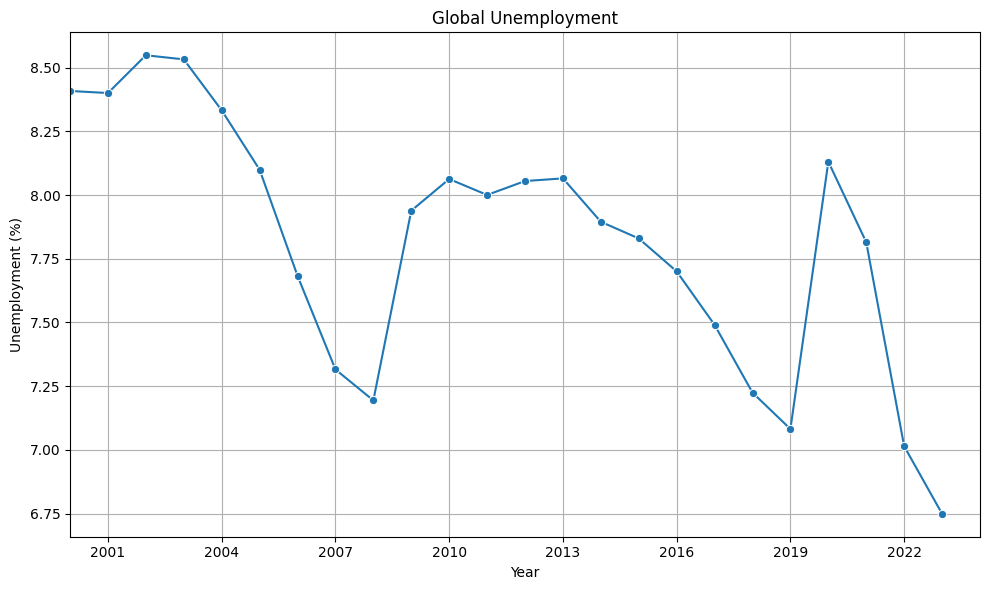

In [28]:
unemployment_summary_filtered = unemployment_summary[
    (unemployment_summary['Year'] >= 2000) & (unemployment_summary['Year'] <= 2024)
]

# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.lineplot(data=unemployment_summary_filtered, x='Year', y='Unemployment (%)', marker="o")
plt.title("Global Unemployment")
plt.xlabel("Year")
plt.ylabel("Unemployment (%)")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  
plt.xlim(start_year, end_year)  
plt.grid(True)
plt.tight_layout()
plt.savefig("Global Unemployment.pdf")
plt.show()


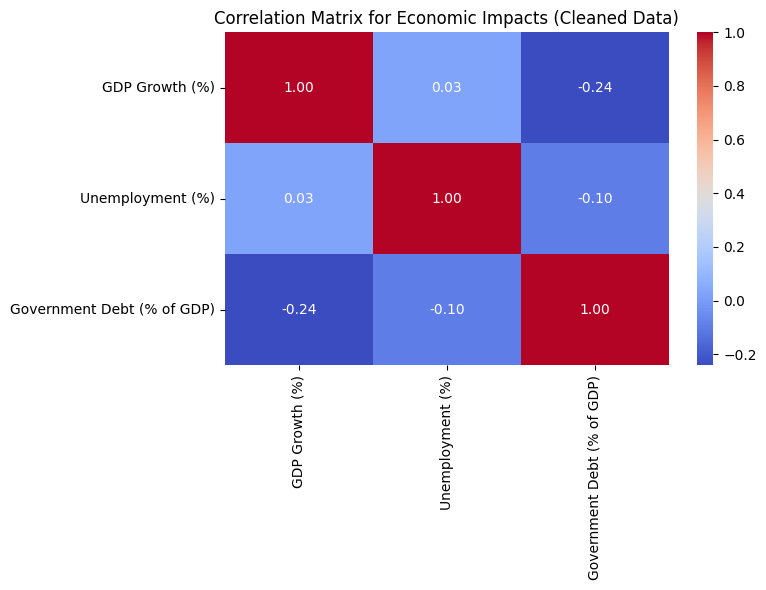

In [29]:
# Compute correlation matrix for the cleaned dataset
cleaned_data = debt_summary_cleaned.merge(
    gdp_summary, on="Year", how="inner"
).merge(
    unemployment_summary, on="Year", how="inner"
)

correlation_matrix = cleaned_data[[
    "GDP Growth (%)", "Unemployment (%)", "Government Debt (% of GDP)"
]].corr()

# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix for Economic Impacts (Cleaned Data)")
plt.tight_layout()
plt.show()


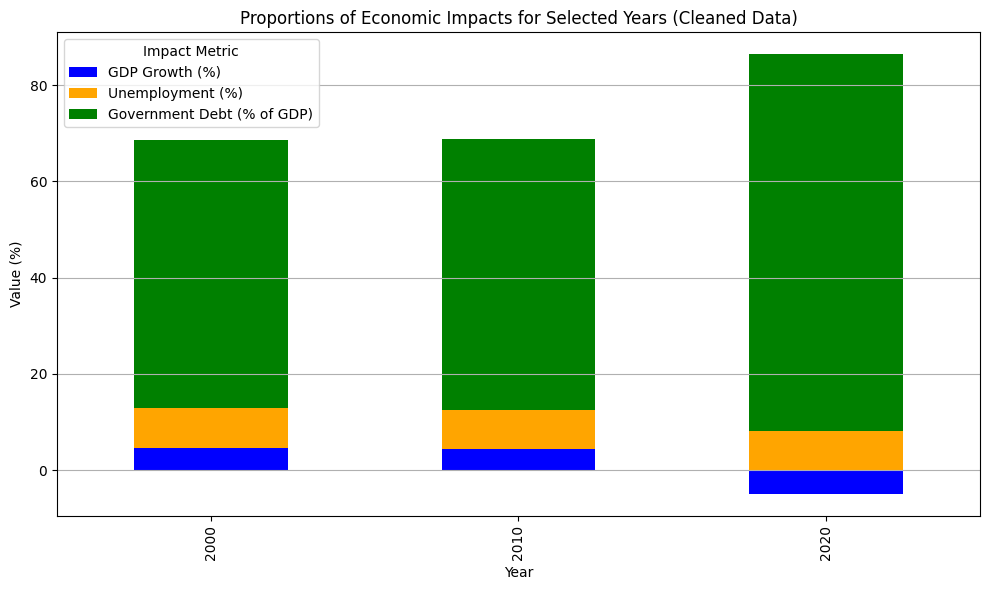

In [30]:
# Filter data for specific years and ensure values are within valid ranges
stacked_data = cleaned_data[cleaned_data["Year"].isin([2000, 2010, 2020])].set_index("Year")

# Plot stacked bar chart
stacked_data[["GDP Growth (%)", "Unemployment (%)", "Government Debt (% of GDP)"]].plot(
    kind="bar", stacked=True, figsize=(10, 6), color=["blue", "orange", "green"]
)
plt.title("Proportions of Economic Impacts for Selected Years (Cleaned Data)")
plt.xlabel("Year")
plt.ylabel("Value (%)")
plt.legend(title="Impact Metric")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
